<a href="https://colab.research.google.com/github/shimul090/portfolio/blob/master/GetLoyalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Install Packages

In [ ]:
!pip install hampel
!pip install pwlf
!pip install EMD-signal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp311-cp311-linux_x86_64.whl size=219583 sha256=e063d22d1b3507b972e18c6ff5f8a19cb9aa0b45595db9d31b60cc048e4befb2
  Stored in directory: /root/.cache/pip/wheels/fd/e9/7e/ad82a52cf81975fce3dd6ae0e00bf26787b546e2518ad861d4
Successfully built hampel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00


## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import scipy
from PyEMD import EEMD

from sklearn.metrics import mean_squared_error
from operator import add

from hampel import hampel
import pwlf
from statsmodels.sandbox.stats.runs import runstest_1samp

## Functions

### Sine Regression

In [ ]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def fit_sin_fixed_period(tt, yy, fixed_period, amp=None):
    '''Fit a sine wave with a fixed period to the input time sequence.'''
    tt = np.array(tt)
    yy = np.array(yy)

    # Calculate fixed angular frequency
    fixed_omega = 2. * np.pi / fixed_period

    # Define sine function with fixed angular frequency
    def sinfunc(t, A, p, c):
        return A * np.sin(fixed_omega * t + p) + c

    # Make initial guesses for amplitude, phase, and offset
    if amp is None:
      guess_amp = np.std(yy) * (2.**0.5)
    else:
      guess_amp = amp
    guess_phase = 0
    guess_offset = np.mean(yy)
    guess = [guess_amp, guess_phase, guess_offset]

    # Perform curve fitting
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, p, c = popt

    # Define the fitting function
    fitfunc = lambda t: A * np.sin(fixed_omega * t + p) + c

    return {
        "amp": A,
        "omega": fixed_omega,
        "phase": p,
        "offset": c,
        "period": fixed_period,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov)
    }


### Generate x ticks labels

In [ ]:
# generate x ticks labels with dates
def x_ticks_labels(data, skip_days):
  #skip_days = 0 # do not skip any data. We may skip first 26 days which has only 1 trails per day

  # generate date based labels for x ticks
  xticks = range(0,350,25) # 0 to 350, 14 ticks
  xticks_labels = [' '] * len(xticks)
  for i in range(len(xticks)):
    xticks_labels[i] = str(xticks[i]) + ": " + data['Date'][xticks[i]+skip_days]
  return xticks, xticks_labels

### Error Calculation

In [ ]:
def calculate_mape(actual, predicted):
    # Convert actual and predicted
    # to numpy array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    # Calculate the MAPE value and return
    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

### Randomness Test

In [ ]:
def is_data_random(data):
  #Perform Runs test, runtest_1samp from statsmodels.sandbox.stats.runs
  result = runstest_1samp(data, correction=False)

  print(f"p-value: {result[-1]:.5f}")

  if result[-1] < 0.01:
    print("The null hypothesis can be rejected: Not Random")
    return False
  else:
    print("The null hypothesis cannot be rejected: Random")
    return True

## Download Data CSV Files

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VF5WvQ9HMXR6RVdMr9VXRxkpIX_rcFyk' -O daily_means.csv

--2025-04-21 17:00:50--  https://docs.google.com/uc?export=download&id=1VF5WvQ9HMXR6RVdMr9VXRxkpIX_rcFyk
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.102, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1VF5WvQ9HMXR6RVdMr9VXRxkpIX_rcFyk&export=download [following]
--2025-04-21 17:00:50--  https://drive.usercontent.google.com/download?id=1VF5WvQ9HMXR6RVdMr9VXRxkpIX_rcFyk&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70896 (69K) [application/octet-stream]
Saving to: ‘daily_means.csv’

daily_means.csv     100%[===================>]  69.23K  --.-KB/s    in 0.

## Load and Plot Original Means

In [ ]:
data = pd.read_csv('daily_means.csv')

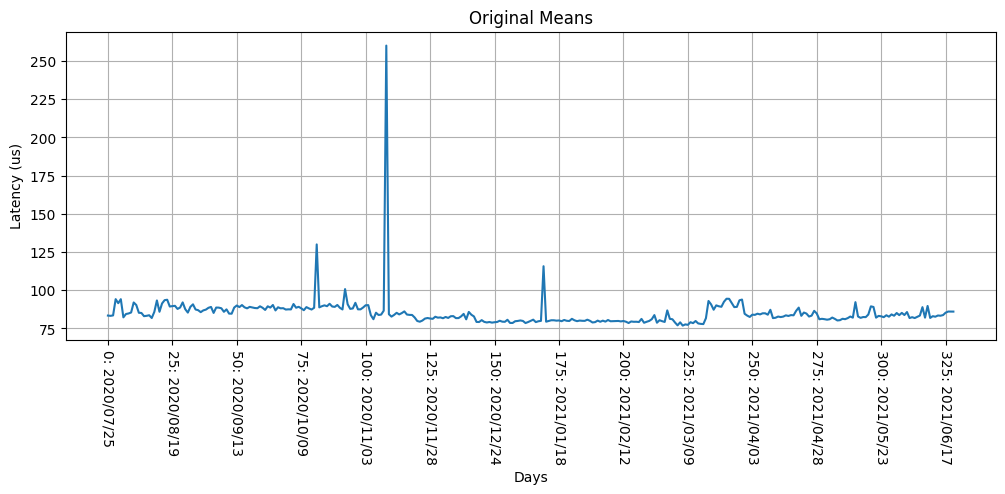

In [ ]:
skip_days = 0 # do not skip any data. We may skip first 26 days which has only 1 trails per day
xticks, xticks_labels = x_ticks_labels(data, skip_days)
original_means = data['GetLoyalty'][skip_days:].reset_index(drop=True)
ax = original_means.plot(xlabel="Days", ylabel="Latency (us)", title="Original Means", figsize=(12,4))
ax.set_xticks(xticks, xticks_labels, rotation=270)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
plt.show()

In [ ]:
outlier_filtered = hampel(data['GetLoyalty'], window_size=24)

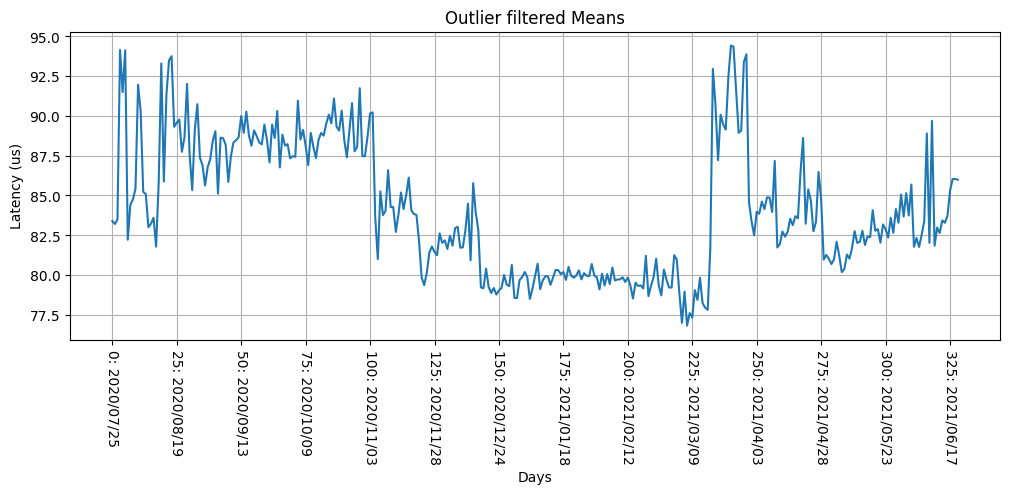

In [ ]:
data['cleaned_GetLoyalty'] = outlier_filtered.filtered_data
skip_days = 0 # do not skip any data. We may skip first 26 days which has only 1 trails per day
xticks, xticks_labels = x_ticks_labels(data, skip_days)
cleaned_means = data['cleaned_GetLoyalty'][skip_days:].reset_index(drop=True)
ax = cleaned_means.plot(xlabel="Days", ylabel="Latency (us)", title="Outlier filtered Means", figsize=(12,4))
ax.set_xticks(xticks, xticks_labels, rotation=270)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
plt.show()

# Hybrid Analysis

In [ ]:
original_means = data['GetLoyalty'][skip_days:].reset_index(drop=True)
cleaned_means_for_manu = data['cleaned_GetLoyalty'][skip_days:].reset_index(drop=True)

train_size = 301
test_size = len(original_means) - train_size


train_means_manu = cleaned_means_for_manu[:train_size]
test_means_manu = cleaned_means_for_manu[train_size:]

## Linear Regression

In [ ]:
plr = train_means_manu.reset_index()
plr.columns = ['index_column', 'value_column']

myPWLF = pwlf.PiecewiseLinFit(plr['index_column'], plr['value_column'])

breakpoints = np.array([0, 125, 240, 300])
z = myPWLF.fit_with_breaks(breakpoints)

slopes = myPWLF.calc_slopes()
xHat = plr['index_column']
insample_predictions = myPWLF.predict(xHat)

test_indices = range(train_size, len(original_means))
test_predictions = myPWLF.predict(test_indices)

In [ ]:
linear_predictions = np.concatenate([insample_predictions, test_predictions])
linear_residuals = cleaned_means_for_manu - linear_predictions

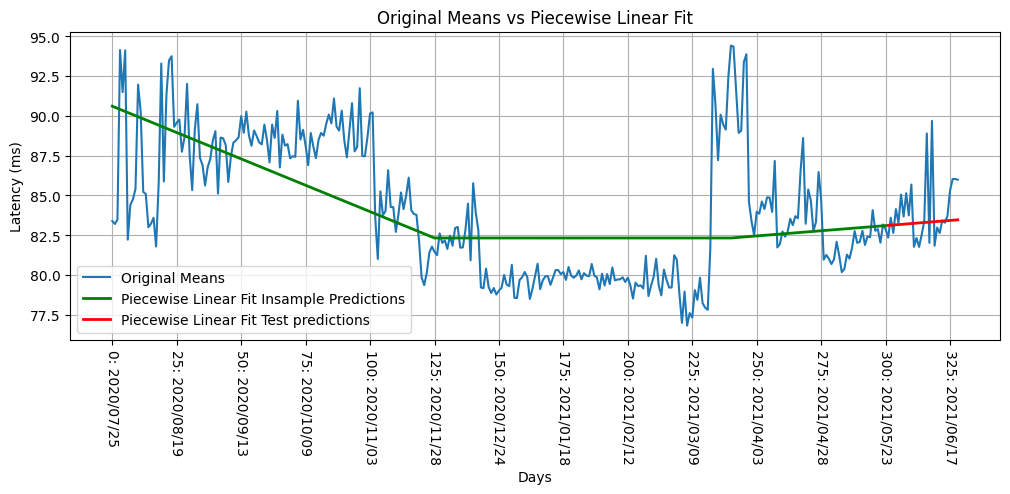

In [ ]:
ax = cleaned_means_for_manu.plot(xlabel="Days", ylabel="Latency (us)", title="Original Means vs Piecewise Linear Fit",
                         figsize=(12,4), label="Original Means")
ax.plot(xHat, insample_predictions, color='green', linewidth=2, label="Piecewise Linear Fit Insample Predictions")
ax.plot(test_indices, test_predictions, color='red', linewidth=2, label="Piecewise Linear Fit Test predictions")
ax.set_xticks(xticks, xticks_labels, rotation=270)
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Latency (ms)")
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
plt.show()

## Seasonal Variation

In [ ]:
train_linear_residuals = linear_residuals[:train_size]
test_linear_residuals = linear_residuals[train_size:]

In [ ]:
x_idx_train = np.array([float(i) for i in range(train_size)])
sin_curve = fit_sin_fixed_period(x_idx_train, train_linear_residuals, 180)

<ipython-input-3-ded72c2a4ac3>:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)


In [ ]:
x_idx_full = np.array([float(i) for i in range(len(original_means))])
sine_predictions = sin_curve["fitfunc"](np.array(x_idx_full))
sine_residuals = linear_residuals - sine_predictions

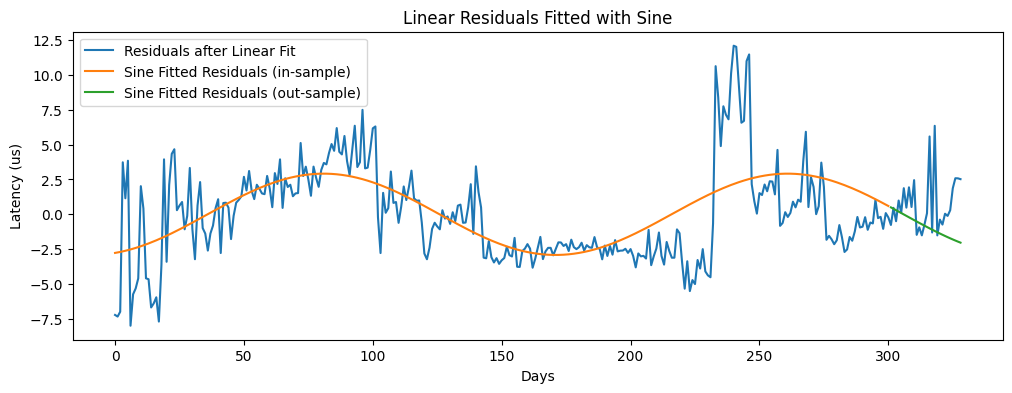

In [ ]:
ax = linear_residuals.plot(label="Residuals after Linear Fit", figsize=(12,4))
ax.plot(sine_predictions[:train_size],label="Sine Fitted Residuals (in-sample)")
ax.plot(range(train_size, train_size+test_size, 1), sine_predictions[train_size:],label="Sine Fitted Residuals (out-sample)")
ax.set_title("Linear Residuals Fitted with Sine")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
ax.legend()
plt.show()

## Monthly Variation

### First Monthly Regression

In [ ]:
train_1st_monthly = sine_residuals[:train_size]
test_1st_montly = sine_residuals[train_size:]

In [ ]:
x_idx_train_1st_monthly = np.array([float(i) for i in range(train_size)])
sin_curve_1st_montly = fit_sin_fixed_period(x_idx_train_1st_monthly, train_1st_monthly, 60)

In [ ]:
x_idx_full_1st_monthly = np.array([float(i) for i in range(len(original_means))])
sine_predictions_1st_monthly = sin_curve_1st_montly["fitfunc"](np.array(x_idx_full_1st_monthly))
sine_residuals_1st_monthly = sine_residuals - sine_predictions_1st_monthly

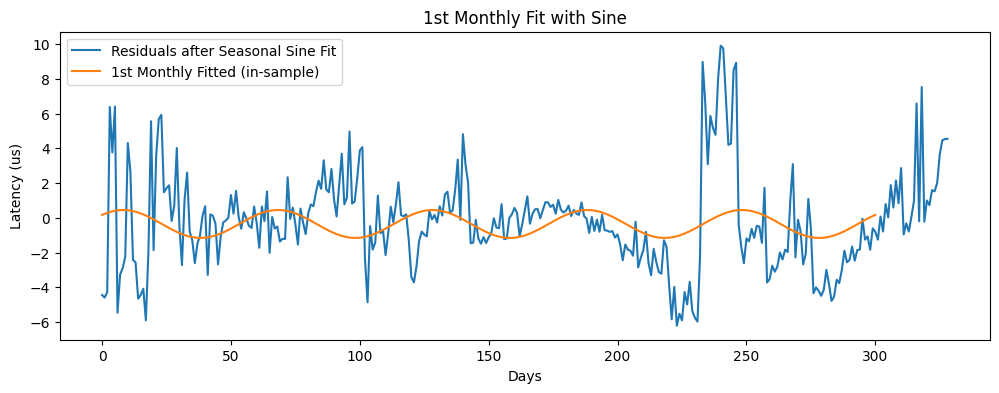

In [ ]:
ax = sine_residuals.plot(label="Residuals after Seasonal Sine Fit", figsize=(12,4))
ax.plot(sine_predictions_1st_monthly[:train_size],label="1st Monthly Fitted (in-sample)")
ax.set_title("1st Monthly Fit with Sine")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
ax.legend()
plt.show()

### Second Monthly Regression

In [ ]:
train_2nd_monthly = sine_residuals_1st_monthly[:train_size]
test_2nd_montly = sine_residuals_1st_monthly[train_size:]

In [ ]:
x_idx_train_2nd_monthly = np.array([float(i) for i in range(train_size)])
sin_curve_2nd_montly = fit_sin_fixed_period(x_idx_train_2nd_monthly, train_2nd_monthly, 30)

In [ ]:
x_idx_full_2nd_monthly = np.array([float(i) for i in range(len(original_means))])
sine_predictions_2nd_monthly = sin_curve_2nd_montly["fitfunc"](np.array(x_idx_full_2nd_monthly))
sine_residuals_2nd_monthly = sine_residuals_1st_monthly - sine_predictions_2nd_monthly

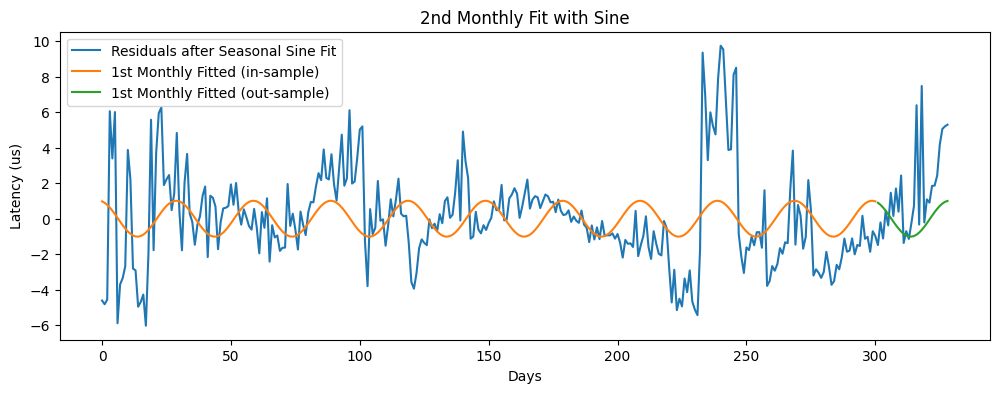

In [ ]:
ax = sine_residuals_1st_monthly.plot(label="Residuals after Seasonal Sine Fit", figsize=(12,4))
ax.plot(sine_predictions_2nd_monthly[:train_size],label="1st Monthly Fitted (in-sample)")
ax.plot(range(train_size, train_size+test_size, 1), sine_predictions_2nd_monthly[train_size:],label="1st Monthly Fitted (out-sample)")
ax.set_title("2nd Monthly Fit with Sine")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
ax.legend()
plt.show()

### Third Monthly Regression

In [ ]:
train_3rd_monthly = sine_residuals_2nd_monthly[:train_size]
test_3rd_montly = sine_residuals_2nd_monthly[train_size:]

In [ ]:
x_idx_train_3rd_monthly = np.array([float(i) for i in range(train_size)])
sin_curve_3rd_monthly = fit_sin_fixed_period(x_idx_train_3rd_monthly, train_3rd_monthly, 21)

In [ ]:
x_idx_full_3rd_monthly = np.array([float(i) for i in range(len(original_means))])
sine_predictions_3rd_monthly = sin_curve_3rd_monthly["fitfunc"](np.array(x_idx_full_3rd_monthly))
sine_residuals_3rd_monthly = sine_residuals_2nd_monthly - sine_predictions_3rd_monthly

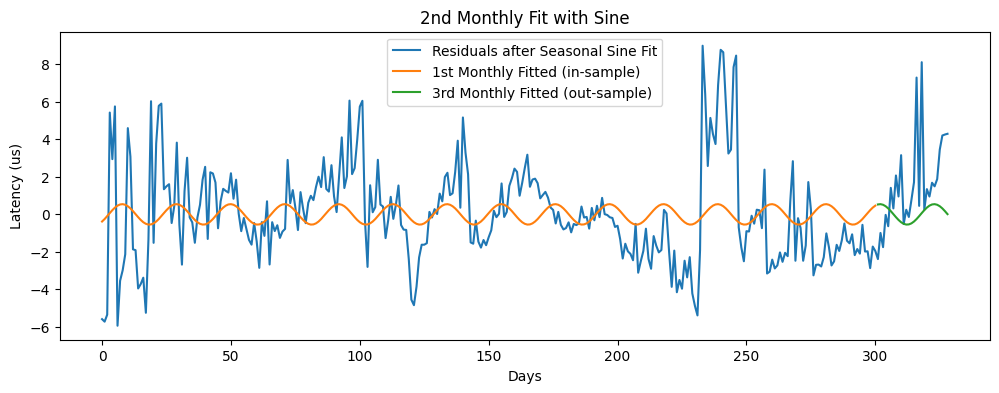

In [ ]:
ax = sine_residuals_2nd_monthly.plot(label="Residuals after Seasonal Sine Fit", figsize=(12,4))
ax.plot(sine_predictions_3rd_monthly[:train_size],label="1st Monthly Fitted (in-sample)")
ax.plot(range(train_size, train_size+test_size, 1), sine_predictions_3rd_monthly[train_size:],label="3rd Monthly Fitted (out-sample)")
ax.set_title("2nd Monthly Fit with Sine")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
ax.legend()
plt.show()

## Daily HWES

### First HWES

In [ ]:
train_1st_hwes = sine_residuals_3rd_monthly[:train_size]
test_1st_hwes = sine_residuals_3rd_monthly[train_size:]

In [ ]:
fitted_model = ExponentialSmoothing(train_1st_hwes,trend='add', seasonal='add', seasonal_periods=77).fit(smoothing_level=0.9, smoothing_trend=0.1, smoothing_seasonal=0.2, optimized=False)
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'HWES Train, Test and Predicted')

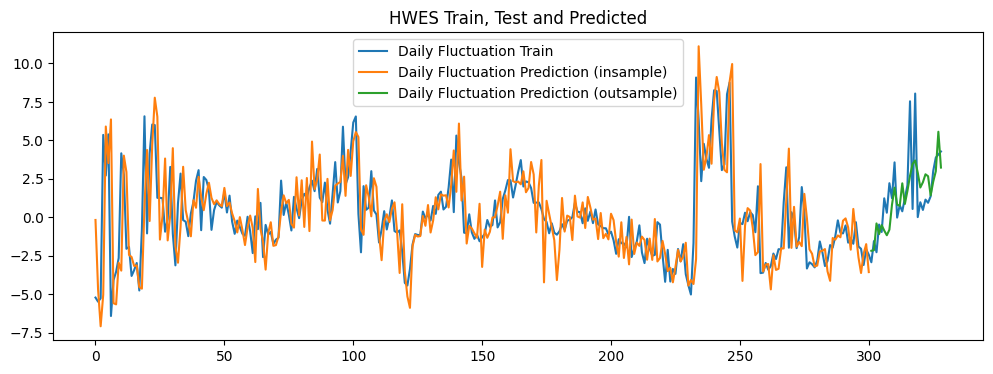

In [ ]:
sine_residuals_3rd_monthly.plot(legend=True,label='Daily Fluctuation Train',figsize=(12,4))
insample_predictions.plot(legend=True,label='Daily Fluctuation Prediction (insample)')
test_predictions.plot(legend=True,label='Daily Fluctuation Prediction (outsample)')
plt.title('HWES Train, Test and Predicted')

#### Randomnes Test

In [ ]:
first_hwes_predictions = np.append(insample_predictions.to_numpy(), test_predictions.to_numpy())
first_hwes_residuals = sine_residuals_3rd_monthly - first_hwes_predictions
is_random = is_data_random(first_hwes_residuals)
print("is random after first hwes:", is_random)

p-value: 0.00681
The null hypothesis can be rejected: Not Random
is random after first hwes: False


### Second HWES

In [ ]:
train_2nd_hwes = first_hwes_residuals[:train_size]
test_2nd_hwes = first_hwes_residuals[train_size:]

In [ ]:
fitted_model_2nd_hwes = ExponentialSmoothing(train_2nd_hwes, trend='add', seasonal='add', seasonal_periods=84).fit(smoothing_level=0.4, smoothing_trend=0.8, smoothing_seasonal=0.1, optimized=False)
test_predictions_2nd_hwes = fitted_model_2nd_hwes.forecast(28)
insample_predictions_2nd_hwes = fitted_model_2nd_hwes.predict(0)

Text(0.5, 1.0, 'HWES Train, Test and Predicted')

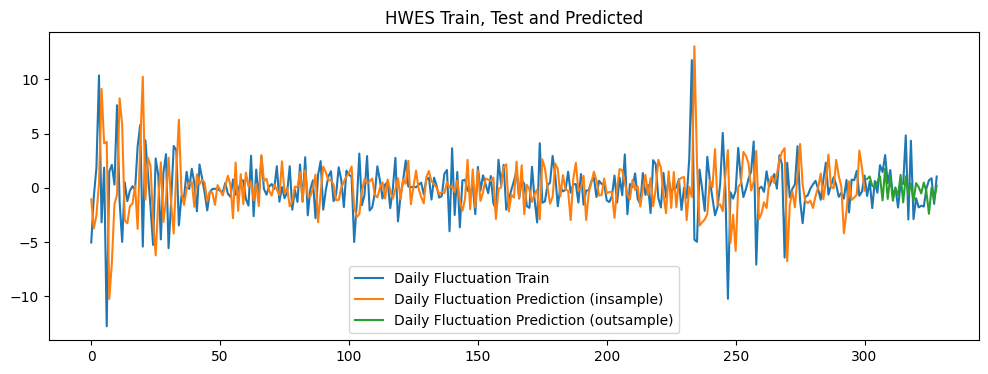

In [ ]:
first_hwes_residuals.plot(legend=True,label='Daily Fluctuation Train',figsize=(12,4))
insample_predictions_2nd_hwes.plot(legend=True,label='Daily Fluctuation Prediction (insample)')
test_predictions_2nd_hwes.plot(legend=True,label='Daily Fluctuation Prediction (outsample)')
plt.title('HWES Train, Test and Predicted')

#### Randomness Test

In [ ]:
second_hwes_predictions = np.append(insample_predictions_2nd_hwes.to_numpy(), test_predictions_2nd_hwes.to_numpy())
second_hwes_residuals = first_hwes_residuals - second_hwes_predictions
is_random = is_data_random(second_hwes_residuals)
print("is random after first hwes:", is_random)

p-value: 0.31605
The null hypothesis cannot be rejected: Random
is random after first hwes: True


## Combine Predictions

In [ ]:
monthly_predictions = list(map(add, sine_predictions_1st_monthly, sine_predictions_2nd_monthly))
monthly_predictions = list(map(add, monthly_predictions, sine_predictions_3rd_monthly))
hwes_predictions = list(map(add, first_hwes_predictions, second_hwes_predictions))

In [ ]:
manual_predictions = list(map(add, linear_predictions, sine_predictions))
manual_predictions = list(map(add, manual_predictions, monthly_predictions))
manual_predictions = list(map(add, manual_predictions, hwes_predictions))

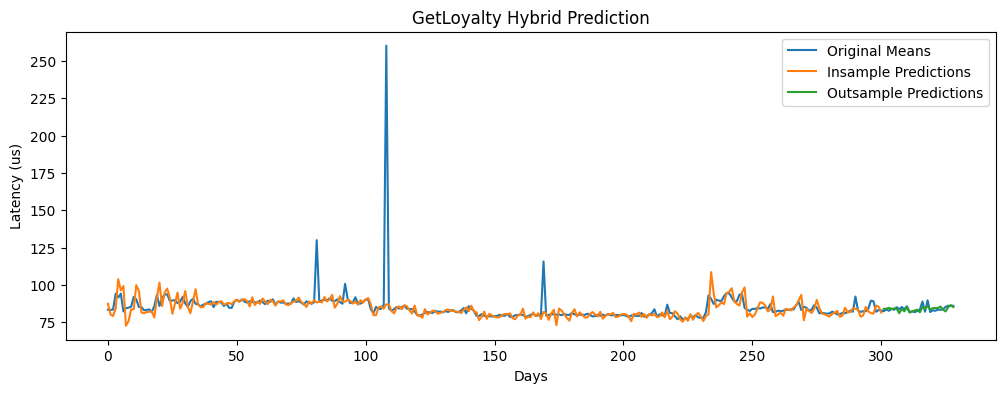

In [ ]:
ax = original_means.plot(label="Original Means", figsize=(12,4))
ax.plot(manual_predictions[0:train_size], label="Insample Predictions")
ax.plot(range(train_size, len(original_means),1),
        manual_predictions[train_size:], label="Outsample Predictions")
ax.legend()
ax.set_title("GetLoyalty Hybrid Prediction")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
plt.show()

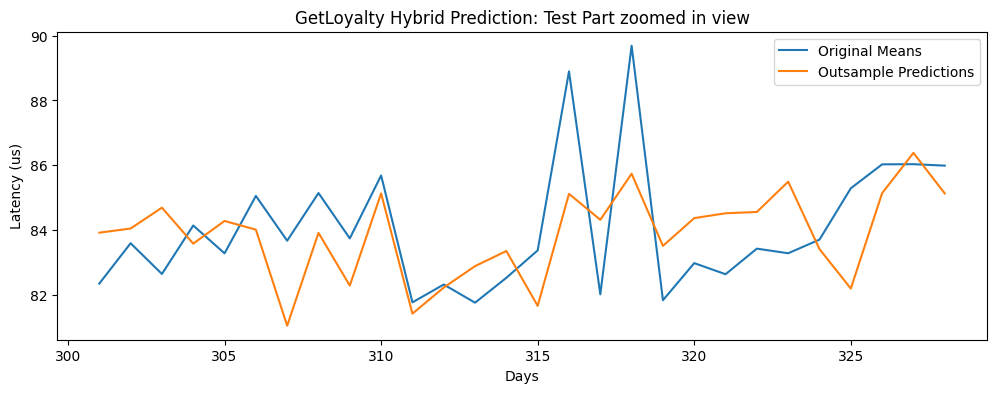

In [ ]:
ax = original_means[train_size:].plot(label="Original Means", figsize=(12,4))
ax.plot(range(train_size, len(original_means),1),
        manual_predictions[train_size:], label="Outsample Predictions")
ax.legend()
ax.set_title("GetLoyalty Hybrid Prediction: Test Part zoomed in view")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
plt.show()

In [ ]:
hwes_mape = calculate_mape(original_means[301:], manual_predictions[train_size:])
print('MAPE of predition using HWES:', hwes_mape)

MAPE of predition using HWES: 1.71


# Automatic Analysis

In [ ]:
cleaned_means_for_eemd = data['cleaned_GetLoyalty'][skip_days:].reset_index(drop=True)
train_original_means = cleaned_means_for_eemd[:train_size]

sample_rate = 0.00001157

In [ ]:
eemd = EEMD(noise_width=0.000000001)
eemd(train_original_means.to_numpy())
eimfs, eres = eemd.get_imfs_and_residue()

In [ ]:
eimfs = eimfs.transpose()

### Forecasting

#### HWES

##### IMF-1

In [ ]:
imf_1 = eimfs[:301, 0]
imf_1 = pd.Series(imf_1)
train_data = imf_1[0:301]

In [ ]:
fitted_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=14).fit(optimized=True)
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'IMF-1 prediction using HWES')

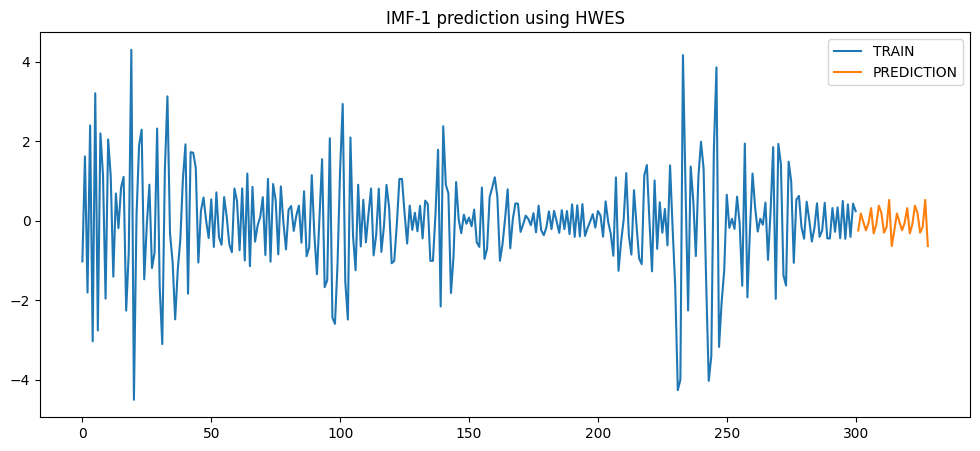

In [ ]:
imf_1.plot(legend=True,label='TRAIN', figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('IMF-1 prediction using HWES')

In [ ]:
index = range(329)
predicted_imf_1 = pd.Series(index=index)
predicted_imf_1[0:301] = insample_predictions
predicted_imf_1[301:329] = test_predictions

##### IMF-2

In [ ]:
imf_2 = eimfs[:301, 1]
imf_2 = pd.Series(imf_2)
train_data = imf_2[0:301]

In [ ]:
fitted_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=7).fit(optimized=True)
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'IMF-2 prediction using HWES')

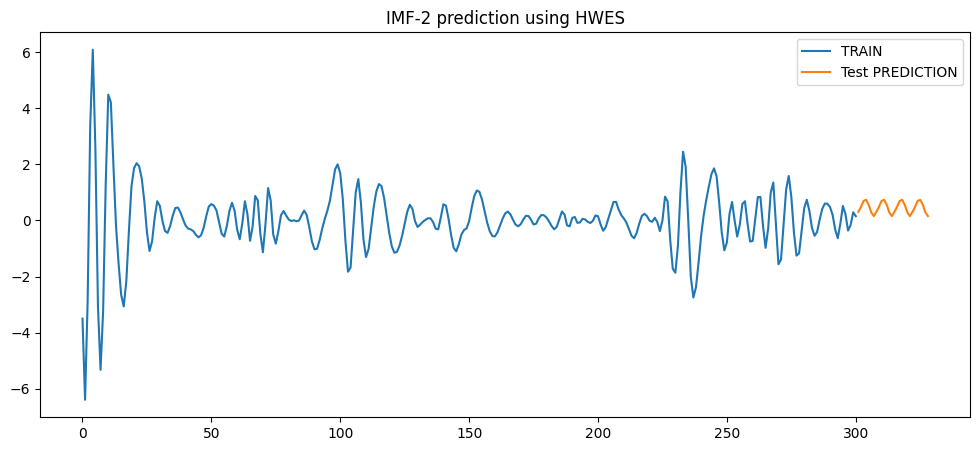

In [ ]:
imf_2.plot(legend=True,label='TRAIN', figsize=(12,5))
test_predictions.plot(legend=True,label='Test PREDICTION')
plt.title('IMF-2 prediction using HWES')

In [ ]:
predicted_imf_2 = pd.Series(index=index)
predicted_imf_2[0:301] = insample_predictions
predicted_imf_2[301:329] = test_predictions

##### IMF-3

In [ ]:
imf_3 = eimfs[:301, 2]
imf_3 = pd.Series(imf_3)
train_data = imf_3[0:301]

In [ ]:
fitted_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=14).fit(optimized=True)
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'IMF-3 prediction using HWES')

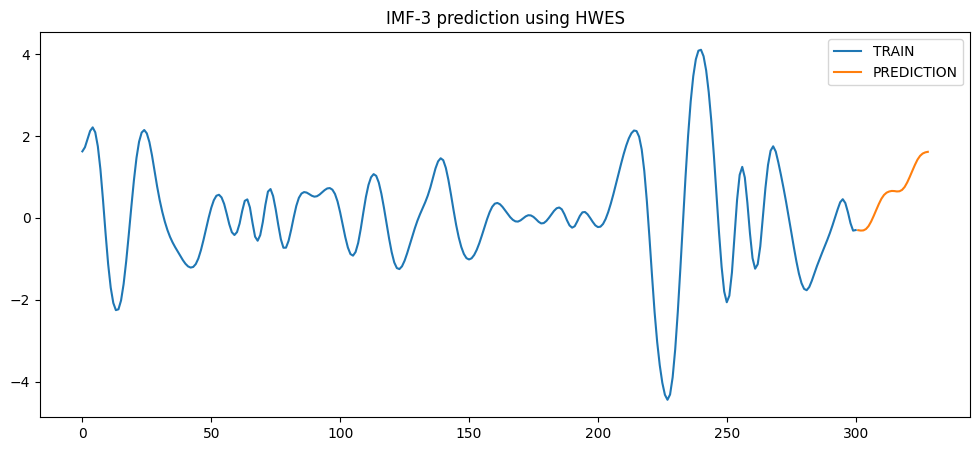

In [ ]:
train_data.plot(legend=True,label='TRAIN', figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('IMF-3 prediction using HWES')

In [ ]:
predicted_imf_3 = pd.Series(index=index)
predicted_imf_3[0:301] = insample_predictions
predicted_imf_3[301:329] = test_predictions

##### IMF-4

In [ ]:
imf_4 = eimfs[:301, 3]
imf_4 = pd.Series(imf_4)
train_data = imf_4[0:301]

In [ ]:
fitted_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=42).fit(optimized=True)
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'IMF-4 prediction using HWES')

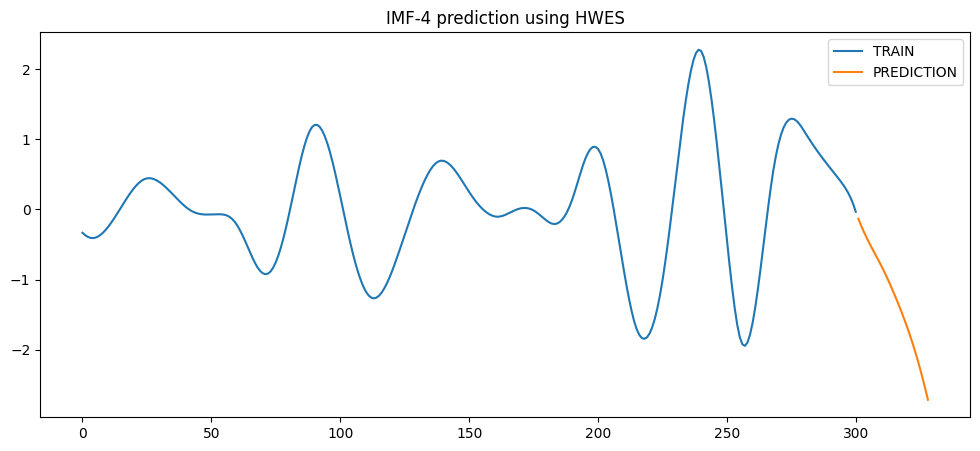

In [ ]:
train_data.plot(legend=True,label='TRAIN', figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('IMF-4 prediction using HWES')

In [ ]:
predicted_imf_4 = pd.Series(index=index)
predicted_imf_4[0:301] = insample_predictions
predicted_imf_4[301:329] = test_predictions

##### IMF-5

In [ ]:
imf_5 = eimfs[:301, 4]
imf_5 = pd.Series(imf_5)
train_data = imf_5[0:301]

In [ ]:
fitted_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=60).fit(optimized=True)
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'IMF-5 prediction using HWES')

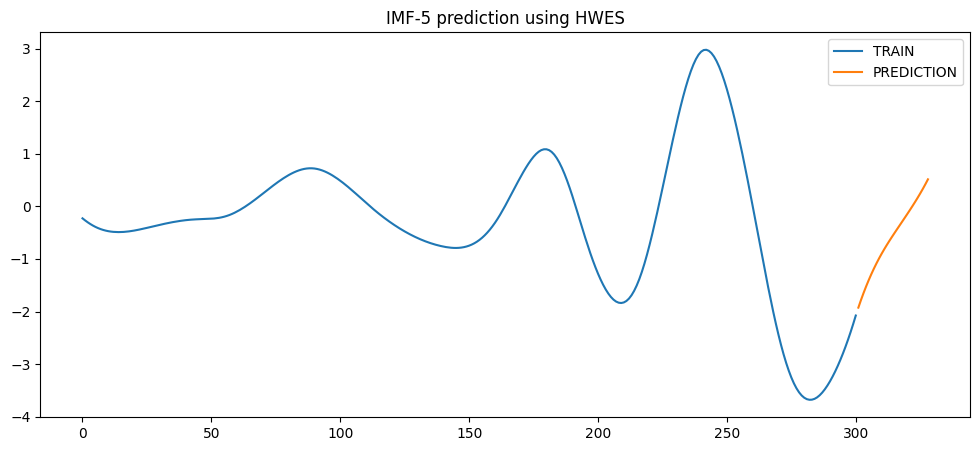

In [ ]:
train_data.plot(legend=True,label='TRAIN', figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('IMF-5 prediction using HWES')

In [ ]:
predicted_imf_5 = pd.Series(index=index)
predicted_imf_5[0:301] = insample_predictions
predicted_imf_5[301:329] = test_predictions

##### Residual

In [ ]:
summed_imf = eimfs[:301, 0] + eimfs[:301, 1] + eimfs[:301, 2] + eimfs[:301, 3]+ eimfs[:301, 4]
residual = train_original_means - summed_imf

residual = pd.Series(residual)
train_data = residual[0:301]

In [ ]:
fitted_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=7).fit()
test_predictions = fitted_model.forecast(28)
insample_predictions = fitted_model.predict(0)

Text(0.5, 1.0, 'Residual prediction using HWES')

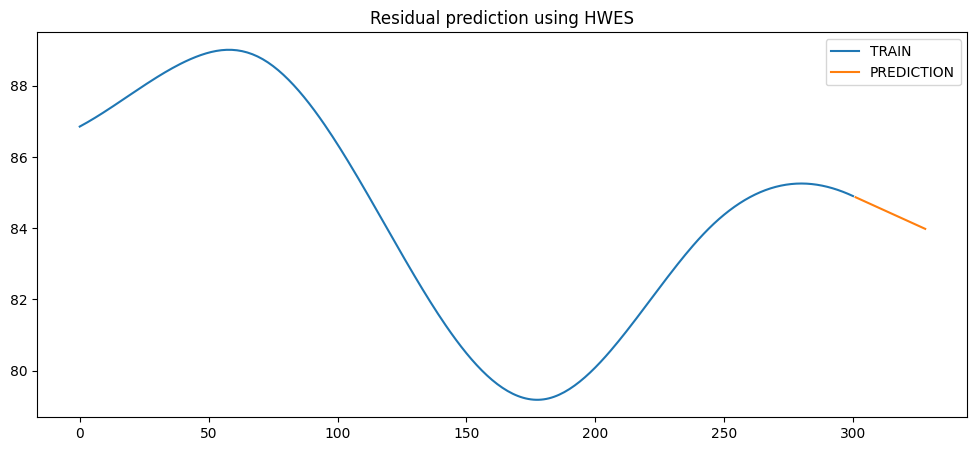

In [ ]:
train_data.plot(legend=True,label='TRAIN', figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Residual prediction using HWES')

In [ ]:
predicted_residual = pd.Series(index=index)
predicted_residual[0:301] = insample_predictions
predicted_residual[301:329] = test_predictions

##### Predicted Signal

In [ ]:
eemd_predicted_signal = predicted_imf_1 + predicted_imf_2 + predicted_imf_3 + predicted_imf_4 + predicted_imf_5 + predicted_residual

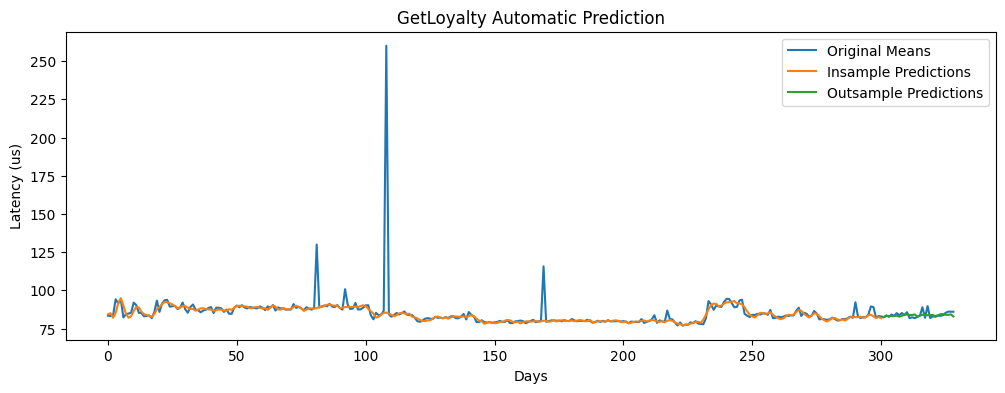

In [ ]:
ax = original_means.plot(label="Original Means", figsize=(12,4))
ax.plot(eemd_predicted_signal[0:train_size], label="Insample Predictions")
ax.plot(range(train_size, len(original_means),1),
        eemd_predicted_signal[train_size:], label="Outsample Predictions")
ax.legend()
ax.set_title("GetLoyalty Automatic Prediction")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
plt.show()

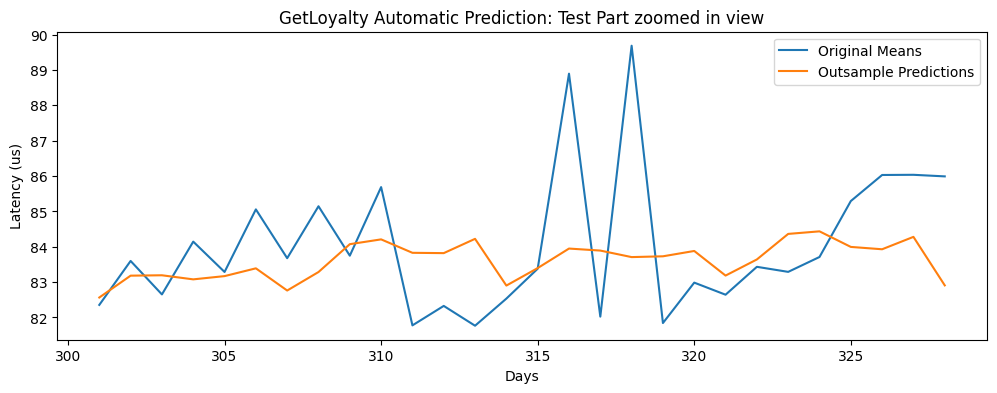

In [ ]:
ax = original_means[train_size:].plot(label="Original Means", figsize=(12,4))
ax.plot(range(train_size, len(original_means),1),
        eemd_predicted_signal[train_size:], label="Outsample Predictions")
ax.legend()
ax.set_title("GetLoyalty Automatic Prediction: Test Part zoomed in view")
ax.set_xlabel("Days")
ax.set_ylabel("Latency (us)")
plt.show()

In [ ]:
hwes_mape = calculate_mape(original_means[301:], eemd_predicted_signal[301:])
print('MAPE of predition using HWES: ', hwes_mape)

MAPE of predition using HWES:  1.73
